## Considerações Iniciais

Treinar modelos que envolvam técnicas de Deep Learning e detecção de imagens geralmente necessitam de uma grande quantia de dados para realizar predições precisas e construir modelos robustos.

É importante também frisarmos que, para os requisitos propostos queremos realizar a tarefa de **Detecção de Objetos**, que difere da tarefa de **Classificação de Imagens** uma vez que essa segunda não se preocupa em encontrar o objeto na imagem (por meio de *bounding box* por exemplo), mas sim informar que imagem é de determinada classe.

Um algoritmo bastante utilizado para tarefas de detecção de objeto em imagens é o algoritmo YOLO, este utiliza da lógica de encadeamento de CNNs (Redes Neurais Convolucionais) para realizar tarefas de visão computacional. Além disso o YOLO é um modelo já treinado em uma enorme base de imagens, fazendo com que ele generalize muito bem a tarefa de detecção.

Com as informações ditas acima, para o objetivo desejado podemos utilizar o modelo YOLO e reaproveitar seus pesos, realizando um processo de Fine-tuning, ou seja iremos ajustá-lo ao nosso dataset de imagens de fumaça repassado. A utilização do YOLO é bem simples e amigável com o pacote `ultralytics`, e a sua versão mais nova é a versão 11, que será utilizada para este projeto.



In [ ]:
# !pip install ultralytics
# !pip install opencv-python

In [1]:
!git clone https://github.com/renneruan/desafio-data-science-2025.git

Cloning into 'desafio-data-science-2025'...
remote: Enumerating objects: 3277, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 3277 (delta 10), reused 44 (delta 6), pack-reused 3228 (from 1)
Receiving objects: 100% (3277/3277), 133.29 MiB | 20.24 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Updating files: 100% (4642/4642), done.


In [3]:
%cd desafio-data-science-2025/

/content/desafio-data-science-2025


In [6]:
# !pip install -r requirements.txt

In [8]:
import os
import shutil
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from ultralytics import YOLO
from src.smoke_detection.utils.commons import get_latest_folder

## Coleta das Imagens



Com a utilização do YOLO em mente, precisamos de um dataset que possua imagens e suas correspondências de fumaça/fogo em bounding box, iniciei a busca de imagens que possam se aproximar das desejadas na biblioteca de imagens https://universe.roboflow.com/.

O objetivo na coleção era encontrar um dataset de imagens possivelmente tiradas por câmeras em torres, como não temos essa informação fácil, escolhemos um dataset que:
- A fumaça/fogo não estivesse tão próximo da câmera;
- Pudessemos traçar uma linha do horizonte definida;
- Sem imagens de drone, satélite ou demais vistas aéreas.
- Neste primeiro momento evitei também datasets com muitas imagens direcionadas para a chama.

Foi utilizada as palavras chaves: *wildfire smoke detection forest fire*.

Um dataset que atendeu as especificações foi o:
https://universe.roboflow.com/tristandeeplearnnig/wildfire-smoke-detection-v7bqc

É possível realizar o download do dataset utilizando o snippet de código abaixo, porém para garantir a disponibilização e evitar a necessidade de cadastro para recuperar a API key, ele também foi baixado em zip e salvo no repositório Git (apenas para caráter de projeto, dados de produção podem ser sensíveis e não devem ser salvos em Git).

In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="_")
# project = rf.workspace("tristandeeplearnnig").project("wildfire-smoke-detection-v7bqc")
# version = project.version(1)
# dataset = version.download("yolov11")


Observações: Por utilizar um dataset baixado de terceiro, a não ser que verifiquemos imagem por imagem não podemos garantir a qualidade da rotulação e criação dos bounding boxes, além de garantir a total falta de Data Leakege por exemplo. A biblioteca YOLO não apresenta funções nativas para verificar em grande escala essa designação. Na próxima seção irei verificar o perfil do bounding box de uma pequena amostra das imagens baixadas.

Temos como quantia:
- Treino: 1.378
- Validação: 147
- Teste: 74

O dataset apresenta apenas uma classe: Smoke

## Verificar o perfil das imagens

Irei realizar uma verificação manual do perfil da rotulagem e das imagens, para isso irei gerar as imagens com as informações de Bounding Box em uma pasta a parte, onde podemos visualizar se as Bounding Box criadas estão correspondente a fumaça.

Para manter este notebook enxuto, criei as funções auxiliares para ler o arquivo YAML de caminho dos dados e criar as imagens com as bounding box nos arquivos `src/utils.py` e `src/image_evaluation.py` respectivamente.

In [11]:
from src.smoke_detection.utils.commons import read_yaml
from src.smoke_detection.utils.image_evaluation import iterate_images_and_labels

all_datasets_path = "datasets/"
dataset_name = "data/"
dataset_path = os.path.join(all_datasets_path, dataset_name)
data_file_path = os.path.join(dataset_path, "data.yaml")

images_with_bb_path = os.path.join(dataset_path, "manual_evaluation", dataset_name)
path_file = read_yaml(data_file_path)

labels = iterate_images_and_labels(
    os.path.join(dataset_path, path_file["train"]),
    images_with_bb_path
)

Arquivo yaml: datasets/data/data.yaml carregado com sucesso.
Imagens para avaliação visual criadas.


Com as imagens geradas na pasta `output/evaluation_images` foi possível perceber algumas características do conjunto de dados utilizado:

- Há a presença de muitas imagens repetidas, por exemplo 2 imagens idênticas ou quase idênticas para o mesmo foco de fumaça; Podemos posteriormente elencar formas de identificar essas duplicidades e excluir dos nossos dados de treino.
- As imagens já estão no tamanho 640x640, tamanho esperado para aplicação ao YOLO;
- Algumas imagens já apresentam uma cópia em flip horizontal, esta poderia ser uma etapa do pré-processamento, uma vez que pegamos a imagem e invertemos horizontalmente para que o modelo possa assimilar características da fumaça tanto crescente para o lado direito como para o esquerdo. Este comportamento levanta a dúvida se essa etapa de pré-processamento segue necessária.

Além disso os labels contidos nos arquivos de rótulo YOLO foram salvos para serem retornados.

In [12]:
# Exemplo de array com objetos (dtype=object)
labels = np.array(labels, dtype=object)
none_elements = labels[labels == None]
none_elements

array([], dtype=object)

Vemos que todas as imagens apresentam uma Bounding Box, ou seja, não há imagens que nos traga a informação apenas de background, em outras condições pode ser interessante adicionar imagens que não possuam o objeto a ser detectado para um melhor treinamento do modelo.

A título de exemplificação vamos coletar aleatoriamente algumas imagens do conjunto de treino (com a Bounding Box desenhada).

In [13]:
image_files = [f for f in os.listdir(os.path.join(dataset_path, path_file["train"])) if f.endswith(('.jpg'))]
random_images = random.sample(image_files, 5)
random_images

['ck0tssirhrq1u0863eoicr5bp_jpeg_jpg.rf.56c5e720712c4f8a6aa8d26d9e86219f.jpg',
 'ck0tyq31o6ryb08488lus3geb_jpeg_jpg.rf.71c5a6e6e4f36c6ba36b676360e34666.jpg',
 'ck0l8di4xoje408487bsrbpj9_jpeg_jpg.rf.8dd8bb9691976f00ca2cf2ab60c5de57.jpg',
 'ck0kcv9km4vc70794bkufs7xw_jpeg_jpg.rf.f9b27d9e98c35017fe8410c00974947e.jpg',
 'ck0txvj9m6otr0848fayj9tte_jpeg_jpg.rf.4a2bce224f7a2a8205399f352eabdb6c.jpg']

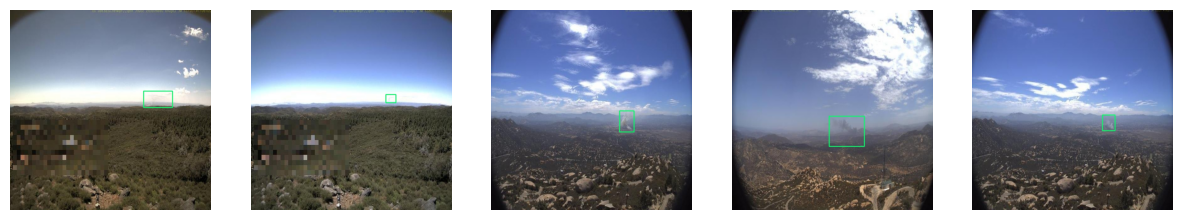

In [14]:
def print_images_in_row(path, images_list):
    plt.figure(figsize=(15, 12))
    for i, img_name in enumerate(images_list):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        # plt.title(img_name)

    plt.show()

print_images_in_row(images_with_bb_path, random_images)


Essa amostra já no mostra várias diferenças entre as imagens como em nível de brilho, escala de cores e saturação, além da possível presença por exemplo de objetos.

## Pré-processamento


Para a etapa de pré-processamento, pesquisei como occo para detectar fumaça sem a utilização de modelos de IA, para verificar quais operações RGB poderiam ser realizadas.


- Normalização/Adequar brilho -> jogar para 0 a 1 Escalonamento (sigmoid) para tan é -1 e 1
- Transformar pra escala cinza
- Aplicar filtro em brilho coeficiente de odson
- rotate
- tensorflow. data augmentation
- conv net - conv mix, conv mix, resnet, mobile net, v66, cascade e racascade, tensorflow
- scikit-image
- Adicionar Ruído -> Filtro
- Tentar verificar bordas ou outros processamentos de artigos

TODO: Pesquisar melhores etapas de pré-processamento para fumaça

https://www.sciencedirect.com/science/article/abs/pii/S1290072902013972
https://www.mdpi.com/2073-8994/12/7/1075
https://www.mdpi.com/1999-4907/15/5/839

## Treinamento do Modelo

Nesta etapa iremos inserir nossas imagens de treino ao modelo YOLOv11 para realizar o Fine-tuning do mesmo a nossa tarefa de detecção de fumaça.

In [16]:
model = YOLO("yolo11n.pt") # pt para modelo pré-treinado

# Treina o modelo no conjunto train da pasta data
# imgsz já tem como valor padrão 640
model.train(
    data=os.path.abspath(data_file_path),
    epochs=15,
    batch=100,
    device=0,
    seed=42
)

print("Treinamento finalizado.")

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/desafio-data-science-2025/datasets/data/data.yaml, epochs=15, time=None, patience=100, batch=100, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

train: Scanning /content/desafio-data-science-2025/datasets/data/train/labels... 1378 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1378/1378 [00:00<00:00, 2407.77it/s]

train: New cache created: /content/desafio-data-science-2025/datasets/data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/desafio-data-science-2025/datasets/data/valid/labels... 147 images, 0 backgrounds, 0 corrupt: 100%|██████████| 147/147 [00:00<00:00, 584.65it/s]

val: New cache created: /content/desafio-data-science-2025/datasets/data/valid/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00078125), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      13.2G       2.11      4.668      1.797        109        640: 100%|██████████| 14/14 [00:20<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.79s/it]

                   all        147        147    0.00315      0.946     0.0907     0.0322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      12.6G      1.736      3.033      1.353        114        640: 100%|██████████| 14/14 [00:16<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

                   all        147        147     0.0488      0.735      0.288      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      12.6G      1.649      2.488      1.314        111        640: 100%|██████████| 14/14 [00:18<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

                   all        147        147    0.00367      0.629      0.241     0.0787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      12.6G      1.578      2.093       1.28        107        640: 100%|██████████| 14/14 [00:19<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

                   all        147        147      0.539     0.0476     0.0718     0.0249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      12.6G      1.558       1.96      1.278         98        640: 100%|██████████| 14/14 [00:20<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all        147        147      0.225      0.313      0.163     0.0711


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      12.6G      1.575      2.031      1.318         78        640: 100%|██████████| 14/14 [00:24<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

                   all        147        147      0.202      0.136      0.123     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      12.6G      1.579      1.868      1.334         78        640: 100%|██████████| 14/14 [00:17<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

                   all        147        147      0.321      0.415      0.315      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      12.6G      1.543      1.668      1.318         78        640: 100%|██████████| 14/14 [00:16<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

                   all        147        147      0.346       0.17      0.118     0.0373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      12.6G      1.492      1.471      1.276         77        640: 100%|██████████| 14/14 [00:18<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

                   all        147        147      0.598      0.544      0.566      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      12.6G      1.486      1.347      1.271         76        640: 100%|██████████| 14/14 [00:18<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

                   all        147        147      0.821       0.51       0.67      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      12.6G      1.421      1.214      1.232         78        640: 100%|██████████| 14/14 [00:18<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

                   all        147        147      0.705      0.748      0.765      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      12.6G      1.387      1.135      1.213         78        640: 100%|██████████| 14/14 [00:17<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

                   all        147        147      0.794       0.68      0.798      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      12.6G      1.313      1.041      1.182         77        640: 100%|██████████| 14/14 [00:17<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

                   all        147        147      0.856       0.85      0.898      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      12.6G      1.308     0.9904      1.172         76        640: 100%|██████████| 14/14 [00:17<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

                   all        147        147      0.835      0.859      0.926      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      12.6G      1.254     0.9494      1.154         78        640: 100%|██████████| 14/14 [00:18<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

                   all        147        147      0.839       0.85      0.904      0.533



15 epochs completed in 0.097 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


                   all        147        147       0.84       0.85      0.898      0.531
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train2
Treinamento finalizado.


Vamos salvar o resultado do melhor modelo `best.pt` na pasta `artifacts/model`. Deve ser rodado antes do eval, uma vez que este irá criar uma nova pasta com os resultados de avaliação.

In [18]:
latest_folder = get_latest_folder(Path("runs/detect"))

best_model = os.path.join(latest_folder, "weights/best.pt")

print(best_model)
destination = "artifacts/model/best.pt"
if os.path.exists(best_model):
    shutil.move(best_model, destination)
    print("Arquivo de melhor modelo movido com sucesso.")
else:
    print("O arquivo não foi encontrado.")

runs/detect/train2/weights/best.pt
Arquivo de melhor modelo movido com sucesso.


## Avaliação do modelo

A chamada para o método `model.val()` retorna a avaliação do modelo nas imagens presentes na pasta `valid` do dataset, ou seja, nosso conjunto de teste, com isso podemos acessar as imagens com gráficos de métrica para análise posterior.

In [19]:
# Avalia no conjunto de validação (valid)
metrics = model.val()

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/desafio-data-science-2025/datasets/data/valid/labels.cache... 147 images, 0 backgrounds, 0 corrupt: 100%|██████████| 147/147 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.58s/it]


                   all        147        147      0.838       0.85      0.904      0.534
Speed: 6.2ms preprocess, 4.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train22



O modelo YOLO possui como resultado as seguintes métricas para a deteção de "objetos" em imagens:

In [20]:
metrics.results_dict

{'metrics/precision(B)': 0.8383723636946852,
 'metrics/recall(B)': 0.8503401360544217,
 'metrics/mAP50(B)': 0.9038915860524149,
 'metrics/mAP50-95(B)': 0.5341664420036911,
 'fitness': 0.5711389564085635}

A partir da [documentação de métricas](https://docs.ultralytics.com/guides/yolo-performance-metrics/#choosing-the-right-metrics) referente ao YOLO, temos a seguinte explicação para as métricas de classe mostradas anteriormente:

- Precision: A acurácia de quantas detecções foram corretas.
- Recall A habilidade do modelo em detectar todas as instâncias do objeto em imagens, nesse caso fumaça.
- mAP50: Mede a precisão média das detecções do modelo considerando um limiar de IoU (Intersection over Union, ou seja o bounding box predito com o verdadeiro) de 50%.
- mAP50-95: Semelhante a métrica anterior porém fornecendo um limiar variável, avaliando o modelo em detecções mais difíceis, importante para casos em que a precisão é essencial.
- A métrica fitness é uma métrica composta para medir o desempenho do modelo de forma geral.

A seguir temos as métricas de velocidade:

In [21]:
metrics.speed

{'preprocess': 6.190585578231233,
 'inference': 4.5451745510209065,
 'loss': 0.00015059863920393834,
 'postprocess': 2.260242850340336}

Temos como métrica de tempo principal o valor de ms necessário para a ação de inferência de uma única imagem.

Podemos visualizar também os gráficos de métrica gerados pelo método val.


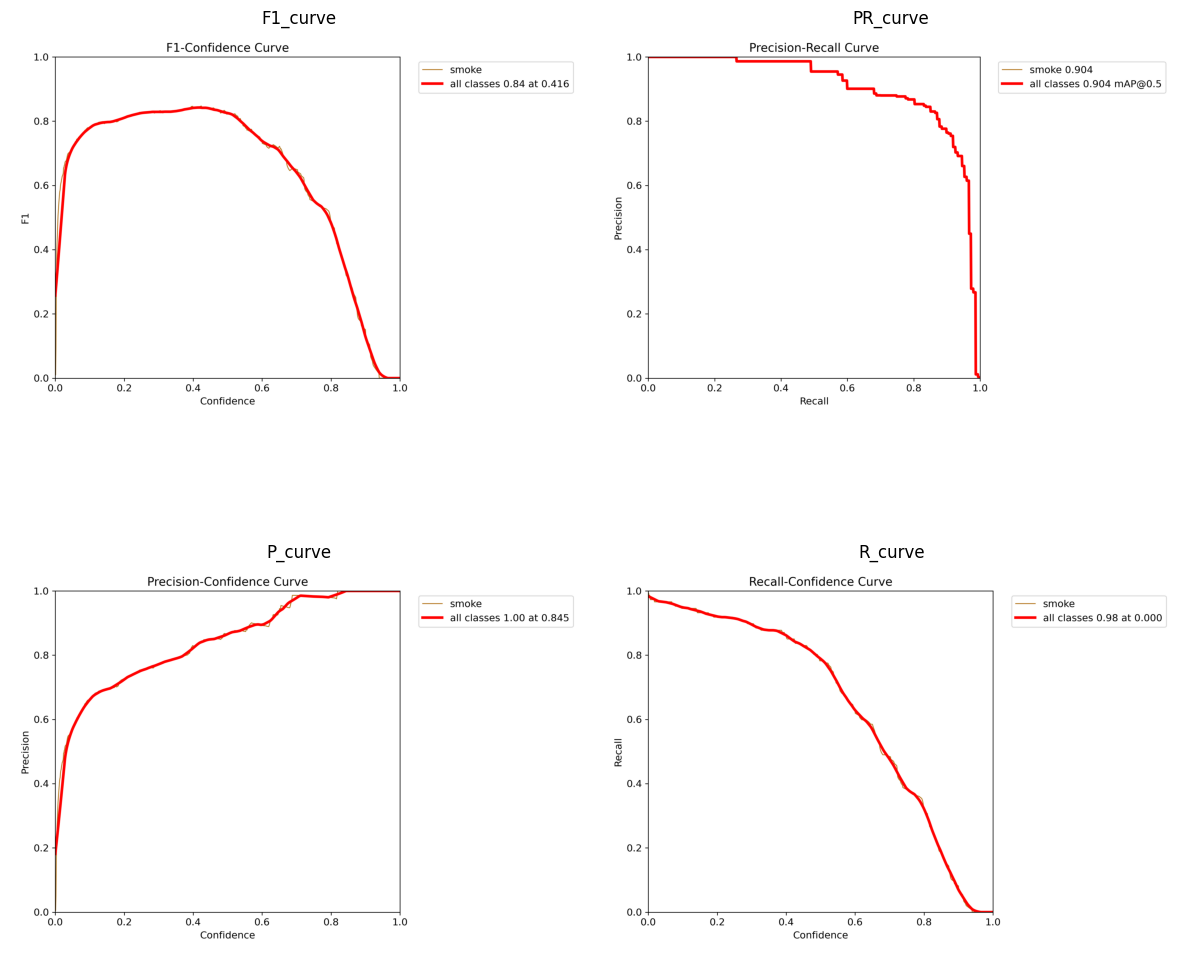

In [23]:
latest_folder = get_latest_folder(Path("runs/detect"))

graphs = [
    "F1_curve",
    "PR_curve",
    "P_curve",
    "R_curve"
]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i, graph_name in enumerate(graphs):
    img_path = Path(os.path.join(latest_folder, f"{graph_name}.png"))
    if img_path.exists():
        img = cv2.imread(img_path)

        ax = axes[i // 2, i % 2]
        ax.imshow(img)
        ax.set_title(graph_name)
        ax.axis("off")

plt.tight_layout()
plt.show()


Temos:
- A curva F1, em que o F1-Score se trata da média harmónica da precisão e da revocação (recall), para a curva temos este valor para diferentes limiares de confiança, visualizamos que na medida que a confiança aumenta a métrica de F1 tende a abaixar. Em um limiar médio de 0.5 temos um F1 Score acima de 0.8.
- A curva de Precision e Recall, no geral essa curva é importante para lidar com problema de desbalanceamento quando há a existência de múltiplas classes, podemos a partir dela analisa o trade off entre as duas métricas.
- Curva de Precisão e Confiança, semelhante a primeira curva porém apenas para precisão.
- Curva de Recall e Confiança, semelhante a primeira curva porém apenas para revocação.

Podemos verificar também as matrizes de confusão geradas, como só temos apenas uma classe, a matriz de confusão possui apenas os valores de fumaça e background (classe gerada automaticamente).   

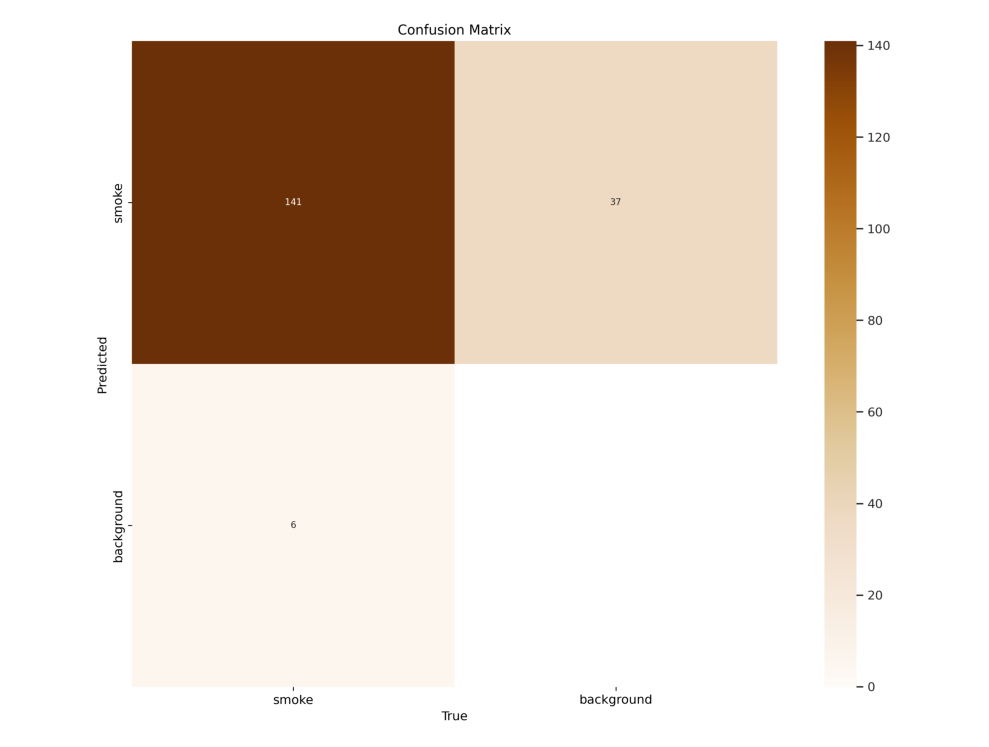

In [24]:
plt.figure(figsize=(10, 10))
img_path = Path(os.path.join(latest_folder, "confusion_matrix.png"))
if img_path.exists():
    img = cv2.imread(img_path)

    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()


Temos a predominância de falsos positivos do que falsos negativos, considerando o o caso de fogo em floresta queremos reduzir ao máximo os casos de falsos negativos, uma vez que deixar a incidência do fogo se alastrar é o pior cenário, enquanto o falso positivo pode ser verificado e validade por um agente humano antes de ser tomada qualquer ação.

## Predição em imagens de teste

In [25]:
test_image_files = [f for f in os.listdir(os.path.join(dataset_path, path_file["test"])) if f.endswith(('.jpg'))]
random_test_images = random.sample(test_image_files, 5)
random_test_images

['ck0khrg9xan7u0721mn5rxpzo_jpeg_jpg.rf.030755fa9e22c118cbe345919d196619.jpg',
 'ck0nepj3s015b0a88py3wvbqu_jpeg_jpg.rf.de3b938218e0a09a065def9a4ad2950b.jpg',
 'ck0kosu846k350794gya7bot0_jpeg_jpg.rf.4d1e5515c244ea76b84bf2b45334e9c8.jpg',
 'ck0m1n0c1hbus0863ti6kd58t_jpeg_jpg.rf.eb93fb80590669f5f0156aebed417cbc.jpg',
 'ck0nftcfgka7e0848a9ie2b3b_jpeg_jpg.rf.792243de554062c1def618b87c5bad5d.jpg']

In [32]:
results = {}
for image in random_test_images:
    test_image = os.path.join(
        dataset_path,
        path_file["test"],
        image
    )

    results[test_image] =  model(test_image)

print(results)


image 1/1 /content/desafio-data-science-2025/datasets/data/test/images/ck0khrg9xan7u0721mn5rxpzo_jpeg_jpg.rf.030755fa9e22c118cbe345919d196619.jpg: 640x640 1 smoke, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/desafio-data-science-2025/datasets/data/test/images/ck0nepj3s015b0a88py3wvbqu_jpeg_jpg.rf.de3b938218e0a09a065def9a4ad2950b.jpg: 640x640 1 smoke, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/desafio-data-science-2025/datasets/data/test/images/ck0kosu846k350794gya7bot0_jpeg_jpg.rf.4d1e5515c244ea76b84bf2b45334e9c8.jpg: 640x640 2 smokes, 9.0ms
Speed: 1.7ms preprocess, 9.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/desafio-data-science-2025/datasets/data/test/images/ck0m1n0c1hbus0863ti6kd58t_jpeg_jpg.rf.eb93fb80590669f5f0156aebed417cbc.jpg: 640x640 1 smoke, 8.2ms
Speed: 1.7ms preprocess

datasets/data/test/images/ck0khrg9xan7u0721mn5rxpzo_jpeg_jpg.rf.030755fa9e22c118cbe345919d196619.jpg
datasets/data/test/images/ck0nepj3s015b0a88py3wvbqu_jpeg_jpg.rf.de3b938218e0a09a065def9a4ad2950b.jpg
datasets/data/test/images/ck0kosu846k350794gya7bot0_jpeg_jpg.rf.4d1e5515c244ea76b84bf2b45334e9c8.jpg
datasets/data/test/images/ck0m1n0c1hbus0863ti6kd58t_jpeg_jpg.rf.eb93fb80590669f5f0156aebed417cbc.jpg
datasets/data/test/images/ck0nftcfgka7e0848a9ie2b3b_jpeg_jpg.rf.792243de554062c1def618b87c5bad5d.jpg


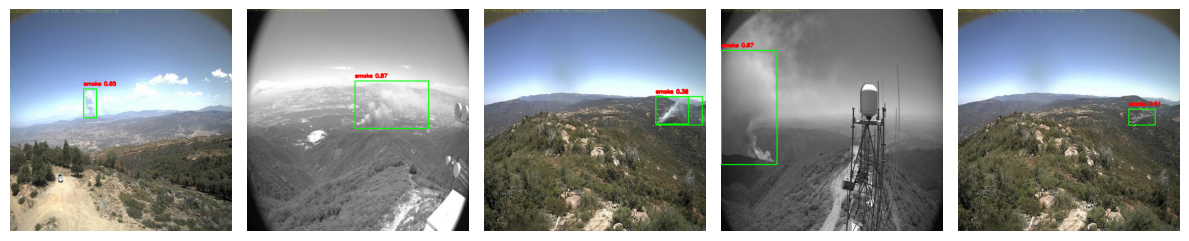

In [36]:
fig, axes = plt.subplots(1, 5, figsize=(12, 12))

for i, (image_path, image_results) in enumerate(results.items()):
  print(image_path)
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  for result in image_results:
    boxes = result.boxes
    for box in boxes:
      x1, y1, x2, y2 = map(int, box.xyxy[0])

      # Score de confiança
      conf = float(box.conf[0])

      # Classe de fumaça (smoke)
      cls = int(box.cls[0])
      label = f"{model.names[cls]} {conf:.2f}"

      img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

      img = cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (255, 0, 0), 2, cv2.LINE_AA)

  ax = axes[i]
  ax.imshow(img)
  # ax.set_title(f"Imagem {i+1}")
  ax.axis("off")

plt.tight_layout()
plt.show()


In [37]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"
# !zip -r /content/project.zip /content/

# from google.colab import files
# files.download('/content/project.zip')

A saída de streaming foi truncada nas últimas 5000 linhas.
  adding: content/desafio-data-science-2025/datasets/data/train/images/ck0nfrec983h90701yvzbsczw_jpeg_jpg.rf.4640b92ea4bc613b967e7b9a9abc2bbe.jpg (deflated 2%)
  adding: content/desafio-data-science-2025/datasets/data/train/images/ck0kkv2jf8pil09448qnz1ndu_jpeg_jpg.rf.3ef6e8b98204687a0fc6864764c6099b.jpg (deflated 4%)
  adding: content/desafio-data-science-2025/datasets/data/train/images/ck0qd6v51ib0j0701sf2wolfq_jpeg_jpg.rf.d75f1f96935d0073fec4b0745983301b.jpg (deflated 1%)
  adding: content/desafio-data-science-2025/datasets/data/train/images/ck0u0i88bunv00944unevdbqg_jpeg_jpg.rf.78af7862c52d1abe137de8103da5ee99.jpg (deflated 3%)
  adding: content/desafio-data-science-2025/datasets/data/train/images/ck0kmh9hhkg5e0a46we9ywaxl_jpeg_jpg.rf.5f963cba97837863db5fc31786490b83.jpg (deflated 2%)
  adding: content/desafio-data-science-2025/datasets/data/train/images/ck0neh5qnjfoh0848s35xyyj8_jpeg_jpg.rf.92a835e63feca310211add438fd4cc9b

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>